In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal

In [2]:
def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [323]:
# fft class

class fft_:
    
    '''
    Does fft spectrum with accelerometer data
    
    '''
    def __init__(self, timesteps, sigl, cutoff = 200):
        self.timesteps = timesteps
        self.sigl = sigl - np.mean(sigl)
        self.log_rate = len(self.timesteps)*(1/(np.round(np.max(self.timesteps), decimals = 1)))
        
    
    def butter_highpass(self, order=5):
        self.order = order
        nyq = 0.5 * self.log_rate
        normal_cutoff = self.cutoff / nyq
        b, a = signal.butter(self.order, normal_cutoff, btype='high', analog=False)
        return b,a

    def butter_highpass_filter(self, sigToFilter, cutoff = 200, order=5):
        self.cutoff = cutoff
        b, a = self.butter_highpass()
        newSig = np.concatenate([np.flip(sigToFilter[0:5000], axis = 0),
                                 sigToFilter, 
                                 np.flip(sigToFilter[15000:len(sigToFilter)], axis = 0) ])
        self.newSig = newSig
        y = signal.filtfilt(b, a, newSig)
        self.filtered_sigl = y[5000:25000]
        
    
    def filterAcc(self):
        self.butter_highpass_filter(sigToFilter= self.sigl, cutoff = 220)
        self.filtered_acc = self.filtered_sigl - np.mean(self.filtered_sigl)
    
    
    def doubleIntegrate(self, sigToIntegrate):
        vel = np.cumsum(sigToIntegrate)/self.log_rate
        pos = np.cumsum(vel - np.mean(vel)) / self.log_rate
        self.pos_unfilt = pos - np.mean(pos)
        
        # highpass filter position
        self.butter_highpass_filter(sigToFilter= pos, cutoff = 100)
        self.pos = self.filtered_sigl - np.mean(self.filtered_sigl)
         
    
    def fft_fit(self, inputSignal):
        n =len(inputSignal) # length of the sigl
        k = np.arange(n, step = 1)
        T = n/self.log_rate
        frq = k/T # two sides frequency range
        frq = frq[range(int(n/2))] # one side frequency range

        # fft computing and normalization (note that *2 is so that it is scaled properly)
        Y = np.fft.fft(inputSignal)/n *2 
        Y = Y[range(int(n/2))]

        # calculate top frequency
        ind = np.argpartition(abs(Y), -4)[-4:]
        
        # Find highest point on the spectrum
        self.peakFrq = frq[ind[::-1]]
        self.pwr = (abs(Y)[ind[::-1]])
        
        self.dominant_freq = [x for (y,x) in sorted(zip(self.pwr,self.peakFrq), reverse = True)][0]
        self.max_amp = self.pwr[self.peakFrq == self.dominant_freq]
        self.Y = Y
        self.frq = frq
        self.fftSignal = inputSignal
        
        
        
    def plot_fft(self, title = ""):    
        plt.figure(figsize=(10,4))
        gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

        # create subplot 1
        ax1 = plt.subplot(gs[0])
        ax1.plot(self.timesteps[0:len(self.fftSignal)],self.fftSignal, color = 'black', linewidth=0.5)
        ax1.set_title(title + " signal")
    
        # subplot 2
        ax2 = plt.subplot(gs[1])
        ax2.plot(self.frq, abs(self.Y), color = "black", linewidth=0.5)
        ax2.plot(self.dominant_freq, self.max_amp,'o', color = 'black', markersize = 5)
        ax2.set_xlim(-0, 1003)
        ax2.set_title(title + " FFT spectrum")
        plt.show()

In [158]:
# forget about envelope for now -- just find position amplitude for all recordings
HeavyLight = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/02_HeavyLight_cleaned.csv"
hl = pd.read_csv(HeavyLight)

dd = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehavior_HeavyLight/"

allFolders = np.unique(hl.accFileAndFolder)

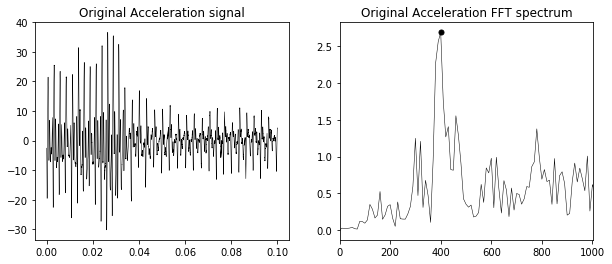

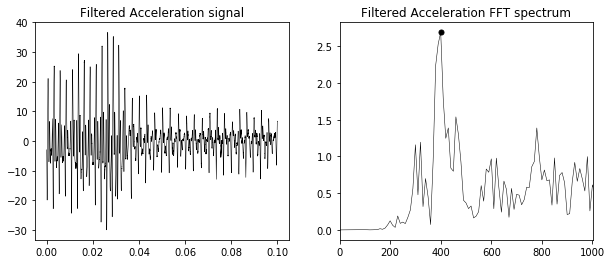

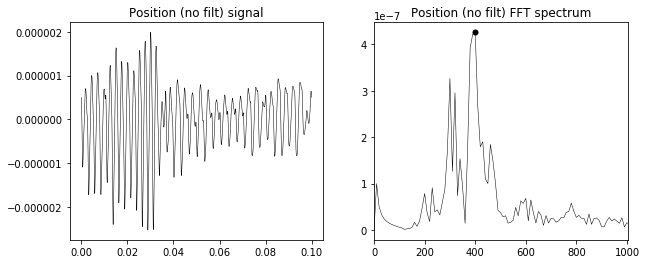

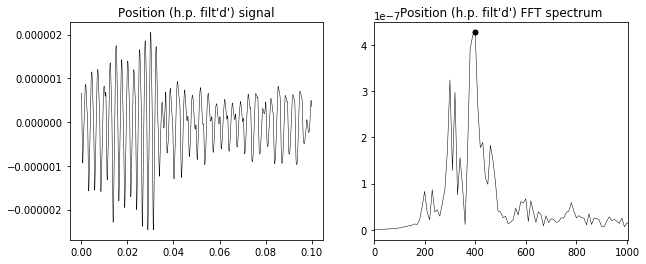

1.1808137987e-06


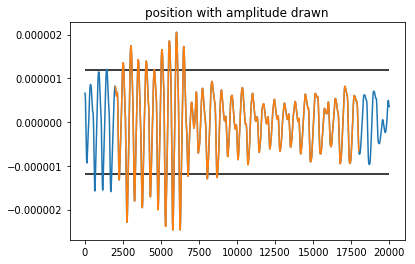

In [360]:
foldNum = 2
ii += 1
tmpF = os.path.join(dd, allFolders[foldNum])
tmpDF = pd.read_csv(tmpF, header = None)
tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]

fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]

ar = accRecs[ii]
tmpdf1 = readMyFile(os.path.join(fold, ar))
timesteps = tmpdf1.iloc[:,0 ]
sig = np.array(tmpdf1.iloc[:,1]*1000 / 10.17)

# timesteps = np.linspace(0, 0.1, num = 20000)
# sig = 3.0*np.sin(369*2*np.pi*(timesteps + 0.003)) 

sigProc = fft_(timesteps, sig)
sigProc.fft_fit(sigProc.sigl)
sigProc.plot_fft(title = "Original Acceleration")


sigProc.filterAcc()
#plt.plot(sigProc.newSig)
sigProc.fft_fit(sigProc.filtered_acc)
sigProc.plot_fft(title = "Filtered Acceleration")


sigProc.doubleIntegrate(sigProc.filtered_sigl)
sigProc.fft_fit(sigProc.pos_unfilt)
sigProc.plot_fft(title =  "Position (no filt)")

sigProc.fft_fit(sigProc.pos)
sigProc.plot_fft(title =  "Position (h.p. filt'd')")


# envelope
accMxs = pd.Series(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc))).rolling(int(700), center = True, min_periods = 1).max().tolist()
# plt.plot(abs(sigProc.filtered_acc -np.mean(sigProc.filtered_acc)))
# plt.plot(accMxs)
# plt.show()


mxs = pd.Series(abs(sigProc.pos)).rolling(int(700), center = True, min_periods = 1).max().tolist()
# plt.plot(abs(sigProc.pos -np.mean(sigProc.pos)))
# plt.plot(mxs)
# plt.show()

aa = np.array(np.where((np.array(accMxs) > 2.0) & (np.arange(0, len(accMxs)) < 18000) & (np.arange(0, len(accMxs)) > 2000)))
bb = aa.flatten()

if bb.shape[0] > 0:

    plt.plot(sigProc.pos )
    plt.title("position with amplitude drawn")


    plt.plot(bb, sigProc.pos[bb])

    maxCut = np.array(mxs)[bb]
    mm = np.mean(np.unique(maxCut))

    plt.hlines(xmin = 0, xmax = 20000, y = [mm, - mm])
    print(np.mean(np.unique(mm)))

In [349]:
# why does position sometimes have a slope?  does it depend on phase? 
bb.shape


(1718,)

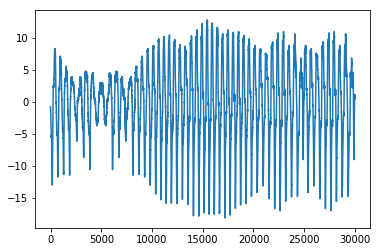

In [213]:
newSig = np.concatenate([np.flip(sigProc.sigl[0:5000], axis = 0),sigProc.sigl, sigProc.sigl[15000:len(sigProc.sigl)]])
plt.plot(newSig)

In [7]:
for foldNum in range(len(allFolders)):
    tmpF = os.path.join(dd, allFolders[foldNum])
    tmpDF = pd.read_csv(tmpF, header = None)
    tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
    tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]



    fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

    accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]



    for ii in range(len(accRecs)):
        # read in data
        ar = accRecs[ii]
        tmpdf1 = readMyFile(os.path.join(fold, ar))

        # compute fft and save
        fft = fft_()

        # convert signal to m/s/s (*1000 / 10.17)
        fft.fit(timesteps = tmpdf1.iloc[:,0 ], signal = np.array(tmpdf1.iloc[:,1]*1000 / 10.17))
        #print(fft.dominant_freq, fft.max_amp)

        if ii == 0:
            tmpDF2 = np.hstack([ar, fft.dominant_freq, fft.max_amp[0], fft.amp_pos])

        else:
            tmpDF2 = np.vstack([tmpDF2, np.hstack([ar, int(fft.dominant_freq), fft.max_amp[0], fft.amp_pos])])
        
        #print(fft.dominant_freq)
        #fft.plot_fft()

    tmpDF2 = pd.DataFrame(tmpDF2)
    tmpDF2.columns = ["filename", "freq", "acc_amplitude_fft", "pos_amplitude_fft" ]
    tmpDF2.sort_values(by = "filename", inplace = True)
    tmpDF2.reset_index(inplace = True, drop = True)
    tmpDF2["fname_short"] = ["_".join(tmpDF2.filename[jj].split("_")[0:8]) for jj in range(len(tmpDF2))]


    tmpDF3 = pd.merge(tmpDF2, tmpDF, how = "outer", left_on = "fname_short", right_on = "fname_short")
    tmpDF3["Folder"] = fold.split("/")[-2]

    if(foldNum == 0):
        bigDF = pd.DataFrame(tmpDF3) 
    else:
        bigDF = pd.concat([bigDF, tmpDF3])
    
    print(foldNum)

bigDF.reset_index(drop = True, inplace = True)
bigDF.freq = pd.to_numeric(bigDF.freq)
bigDF.acc_amplitude_fft = pd.to_numeric(bigDF.acc_amplitude_fft)
bigDF.pos_amplitude_fft = pd.to_numeric(bigDF.pos_amplitude_fft)

TypeError: __init__() missing 2 required positional arguments: 'timesteps' and 'sigl'

In [ ]:
for foldNum in range(len(allFolders)):
    tmpF = os.path.join(dd, allFolders[foldNum])
    tmpDF = pd.read_csv(tmpF, header = None)
    tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
    tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]



    fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

    accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]



    for ii in range(len(accRecs)):
        # read in data
        ar = accRecs[ii]
        tmpdf1 = readMyFile(os.path.join(fold, ar))

        # compute fft and save
        fft = fft_()

        # convert signal to m/s/s (*1000 / 10.17)
        fft.fit(timesteps = tmpdf1.iloc[:,0 ], signal = np.array(tmpdf1.iloc[:,1]*1000 / 10.17))
        #print(fft.dominant_freq, fft.max_amp)

        if ii == 0:
            tmpDF2 = np.hstack([ar, fft.dominant_freq, fft.max_amp[0], fft.amp_pos])

        else:
            tmpDF2 = np.vstack([tmpDF2, np.hstack([ar, int(fft.dominant_freq), fft.max_amp[0], fft.amp_pos])])
        
        #print(fft.dominant_freq)
        #fft.plot_fft()

    tmpDF2 = pd.DataFrame(tmpDF2)
    tmpDF2.columns = ["filename", "freq", "acc_amplitude_fft", "pos_amplitude_fft" ]
    tmpDF2.sort_values(by = "filename", inplace = True)
    tmpDF2.reset_index(inplace = True, drop = True)
    tmpDF2["fname_short"] = ["_".join(tmpDF2.filename[jj].split("_")[0:8]) for jj in range(len(tmpDF2))]


    tmpDF3 = pd.merge(tmpDF2, tmpDF, how = "outer", left_on = "fname_short", right_on = "fname_short")
    tmpDF3["Folder"] = fold.split("/")[-2]

    if(foldNum == 0):
        bigDF = pd.DataFrame(tmpDF3) 
    else:
        bigDF = pd.concat([bigDF, tmpDF3])
    
    print(foldNum)

bigDF.reset_index(drop = True, inplace = True)
bigDF.freq = pd.to_numeric(bigDF.freq)
bigDF.acc_amplitude_fft = pd.to_numeric(bigDF.acc_amplitude_fft)
bigDF.pos_amplitude_fft = pd.to_numeric(bigDF.pos_amplitude_fft)

In [ ]:
bigM = []

for foldNum in  range(len(allFolders)):
    tmpF = os.path.join(dd, allFolders[foldNum])
    tmpDF = pd.read_csv(tmpF, header = None)
    tmpDF.columns = ["frq", "MaxMinAmp", "fname_short", "dd", "TT", "AA", "BB"]
    tmpDF.fname_short = [ff.strip() for ff in tmpDF.fname_short]



    fold = os.path.join(dd, allFolders[foldNum]).split("_ampFreq.txt")[0]

    accRecs = [f for f in os.listdir(fold) if not f.startswith(".") ]

    mm = []

    for ii in range(len(accRecs)):
            # read in data
            ar = accRecs[ii]
            tmpdf1 = readMyFile(os.path.join(fold, ar))
            signal = (tmpdf1.iloc[:,1] - np.mean(tmpdf1.iloc[:,1]))*1000 / 10.17
            times = tmpdf1.iloc[:,0]
            mxs = pd.Series(abs(signal)).rolling(int(tmpdf1.shape[0]/28), center = True, min_periods = 1).max().tolist()

            mm.append(np.unique(mxs))

    out = np.concatenate(mm).ravel()
    bigM.append(out)
    print(foldNum)
    #plt.hist(out[out <10], bins = 30, density = True)
    #plt.xlim(0, 10)
    sns.kdeplot(np.array(out[out <15]), bw=0.3)
    #plt.show()

In [ ]:

zz = np.concatenate(bigM).ravel()
plt.hist(zz[zz < 20], density = True, bins = 200)
sns.kdeplot(zz[zz < 20], bw=0.2)
plt.xlim(0, 15)
plt.show()

In [ ]:
       


ii =0
ar = accRecs[ii]
tmpdf1 = readMyFile(os.path.join(fold, ar))

signal = (tmpdf1.iloc[:,1] - np.mean(tmpdf1.iloc[:,1]))*1000 / 10.17
times = tmpdf1.iloc[:,0]
mxs = pd.Series(abs(signal)).rolling(int(tmpdf1.shape[0]/28), center = True, min_periods = 1).max().tolist()
print(int(tmpdf1.shape[0]/28))
plt.plot(abs(signal))
plt.plot(mxs)
plt.show()

plt.hist(mxs)
plt.show()

t2 = times[np.array(mxs) > 2.0]
s2 = signal[np.array(mxs) > 2.0]

fft = fft_()
fft.fit(t2, s2)
fft.plot_fft()

In [ ]:
plt.plot(np.mod(times, 0.01) > 0.005) 

In [ ]:
sig1_amp = np.round(np.mod(times, 0.01), decimals = 1)


signal = (np.mod(times, 0.01) > 0.005)*np.sin(2* np.pi * (times* 200)) #+ 0.2*np.random.randn(len(times))
signal[abs(signal)>0.9] = 2*np.sin(2* np.pi * (times[abs(signal)>0.9]* 200))

signal = signal + ~(np.mod(times, 0.01) > 0.005)*np.sin(2* np.pi * times* 1000)*0.1 #+ np.sin(2* np.pi * (times* 3))


#signal = np.sin(2* np.pi * (times* 100))
#signal[times < 0.07] = np.sin(2* np.pi * times* 1000)*0.1


#signal = 0.8*np.sin(2* np.pi * times* 400) + np.sin(2* np.pi * (times* 200 + 400))


#sig1 = np.sin(2* np.pi * times* 50)


#signal = 5.44 * np.sin(2* np.pi * times* 200) + 4 * np.sin(2* np.pi * times* 400)

#signal = lowess(signal + 0.01*np.random.randn(len(times)), times, frac = 1/20)[:,1]
plt.figure(figsize = [10,10])
plt.plot(signal)
#plt.hlines(xmin = 0, xmax = 20000, y = 0.54)

fft = fft_()
fft.fit(times, signal)
fft.plot_fft()

In [ ]:
from scipy import signal

def highpass_filter(y, sr):
    filter_stop_freq = 70  # Hz
    filter_pass_freq = 100  # Hz
    filter_order = 1001

    # High-pass filter
    nyquist_rate = sr / 2.
    desired = (0, 0, 1, 1)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_audio = signal.filtfilt(filter_coefs, [1], y)
    return filtered_audio

In [ ]:
fc = 0.1
b = 0.08
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
 
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = np.blackman(N)
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

# reverse function
sinc_func = -sinc_func
sinc_func[(N - 1) / 2] += 1

s = list(data['10 Min Std Dev'])
new_signal = np.convolve(s, sinc_func)

trace1 = go.Scatter(
    x=range(len(new_signal)),
    y=new_signal,
    mode='lines',
    name='High-Pass Filter',
    marker=dict(
        color='#424242'
    )
)

layout = go.Layout(
    title='High-Pass Filter',
    showlegend=True
)

trace_data = [trace1]
fig = go.Figure(data=trace_data, layout=layout)
py.iplot(fig, filename='fft-high-pass-filter')

In [ ]:
del signal

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
def sine_generator(timesteps, sinefreq):
    nsamples = len(timesteps)
    w = 2. * np.pi * sinefreq
    y_sine = np.sin(w * timesteps)*3.22
    result = pd.DataFrame({ 
        'data' : y_sine} ,index=timesteps)
    return result

def butter_highpass(cutoff, log_rate, order=5):
    nyq = 0.5 * log_rate
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, log_rate, order=5):
    b, a = butter_highpass(cutoff, log_rate, order=order)
    y = signal.filtfilt(b, a, data)
    return y


timesteps = np.linspace(0, 0.1, num = 20000)
log_rate = 200000 # samples per second
sine_fq = 300

sine_5Hz = sine_generator(timesteps,sine_fq)
sine_fq = 30 #Hz
sine_1Hz = sine_generator(timesteps,sine_fq)
sine = sine_5Hz + sine_1Hz
plt.plot(sine)

In [ ]:
sine = sine_5Hz + sine_1Hz
sig1_amp = np.round(np.mod(timesteps, 0.01), decimals = 1)


sig = (np.mod(timesteps, 0.01) > 0.005*3/2)*np.sin(2* np.pi * (timesteps* 300)) #+ 0.2*np.random.randn(len(times))
sig[abs(sig)>0.9] = 2*np.sin(2* np.pi * (timesteps[abs(sig)>0.9]* 300))

sig = sig + ~(np.mod(timesteps, 0.01) > 0.005)*np.sin(2* np.pi * timesteps* 1000)* 0.1 + np.sin(2* np.pi * (timesteps* 10))
sine['data'] = data
#sine['data'] = sig

In [ ]:
filtered_sine = butter_highpass_filter(sine.data, 200, log_rate)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(sine)
plt.title('generated signal')
plt.subplot(212)
plt.plot(range(len(filtered_sine)),filtered_sine)
plt.title('filtered signal')
plt.show()

In [ ]:
vel = np.cumsum(filtered_sine)/log_rate

pos = np.cumsum(vel - np.mean(vel)) / log_rate

aa = fft_()
aa.fit(timesteps, pos-np.mean(pos))
plt.figure(figsize = [15,10])
plt.plot(timesteps, pos - np.mean(pos))
plt.hlines(xmin = 0, xmax = 0.01, y = [aa.max_amp, 1.8e-06])
aa.plot_fft()
print(aa.max_amp)

In [ ]:
fft = fft_()

In [ ]:
fft.fit(timesteps, filtered_sine)

In [ ]:
fft.plot_fft()

In [ ]:
peakind = signal.find_peaks_cwt(filtered_sine, widths = np.arange(200, 400))
plt.plot(timesteps,filtered_sine)
plt.scatter(timesteps[peakind], np.array(filtered_sine)[peakind], c= 'red')

In [ ]:
 np.array(sine.data)[peakind]

In [ ]:
from scipy import signal
t = timesteps 
t= np.linspace(-1, 1, 200, endpoint=False)
sig  = sine.data
# filtered_sine 
#sig = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1000, 2000)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.plot(sig)
plt.show()

plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [ ]:
# analytical calculate position amplitude
2.0 / (np.pi * 2 * 100)**2

In [ ]:
plt.plot(fft.frq,abs(fft.Y))
print(fft.amp_pos)
plt.xlim(0, 1000)

In [ ]:
vel = np.cumsum(signal)/log_rate

pos = np.cumsum(vel - np.mean(vel)) / log_rate

aa = fft_()
aa.fit(times, pos-np.mean(pos))
plt.figure(figsize = [15,10])
plt.plot(times, pos - np.mean(pos))
plt.hlines(xmin = 0, xmax = 0.01, y = [aa.max_amp, 1.8e-06])
aa.plot_fft()
print(aa.max_amp)

In [ ]:
v2 = np.diff(pos) *log_rate
a2 = np.diff(v2-np.mean(v2)) * log_rate
plt.figure(figsize = [15,10])

plt.plot(pos-np.mean(pos))
plt.show()

plt.plot(v2-np.mean(v2))
plt.show()
plt.plot(a2)
plt.show()


In [ ]:
import pdvega  # import adds vgplot attribute to pandas



In [ ]:
sig1 = np.sin(2* np.pi * times* 350)


signal = 5*np.sin(2* np.pi * times* 352)
signal[abs(sig1) < 0.99] =  sig1

#signal[signal < 0] =  signal[signal < 0]*5
signal = signal + np.random.randn(len(times))*0.4

signal.vgplot.line()

In [ ]:
#ii +=1
ar = accRecs[ii]
tmpdf1 = readMyFile(os.path.join(fold, ar))

signal = (tmpdf1.iloc[:,1] - np.mean(tmpdf1.iloc[:,1]))*1000 / 10.17
times = tmpdf1.iloc[:,0]
mxs = pd.Series(abs(signal)).rolling(int(tmpdf1.shape[0]/28), center = True, min_periods = 1).max().tolist()
print(int(tmpdf1.shape[0]/28))
plt.plot(abs(signal))
plt.plot(mxs)

plt.show()
plt.plot(signal)
plt.show()
plt.plot(signal[0:5000])



signal[0:5000].vgplot.line()



In [ ]:
fft = fft_()
fft.fit(times, signal-np.mean(signal))
fft.plot_fft()

In [ ]:
sig1 = np.sin(2* np.pi * times* 50)


signal = 5.44 * np.sin(2* np.pi * times* 200) + 4 * np.sin(2* np.pi * times* 400)
plt.plot(signal)

fft = fft_()
fft.fit(times, signal)
fft.plot_fft()

In [ ]:
len(times)

In [ ]:
print(bigDF.shape)
bigDF.head()

In [ ]:
print(hl.shape)
hl.datetime = [ff.strip() for ff in hl.datetime]
hl.head()

In [ ]:
# merge bigDF and hl

totalDF = pd.merge(bigDF, hl, left_on = ["fname_short", "freq"], right_on=["datetime", "freq"], how = "inner")
totalDF.shape

In [ ]:
totalDF.head()

In [ ]:
# change column names
totalDF2 =totalDF.rename(columns = {'amp_acc':'MinMax_amp_acc_m/s/s', 
                                    'amp': 'MinMax_amp_Volts', 
                                   'acc_amplitude_fft': 'acc_amplitude_fft_m/s/s', 
                                    'pos_amplitude_fft': 'pos_amplitude_fft_m'
                                   })
totalDF2.drop(["frq", "TT", "AA", "BB", "dd", "fname_short", "MaxMinAmp"], axis = 1, inplace = True)
totalDF2.head()


In [ ]:
plt.scatter(x = totalDF2['acc_amplitude_fft_m/s/s'], y = totalDF2['pos_amplitude_fft_m']*10**7, s= 1)

In [ ]:
# write to file
totalDF2.to_csv("/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/02_1_HeavyLight_cleaned_posAdded.csv", index = False)

In [ ]:
plt.scatter(x = totalDF2.MinMax_amp_Volts, y = totalDF2['acc_amplitude_fft_m/s/s'], s = 1)

In [ ]:
ar = accRecs[2]
stt = time.time()
dta = readMyFile(os.path.join(fold, ar))


#fft practice

#xx = np.linspace(0, 0.1, num = 1000)
#act = 2.09906008*np.sin(350*2*np.pi*xx) 
xx = dta.iloc[:,0 ]
act = dta.iloc[:,1]*1000 / 10.17

#plt.plot(xx, act)

log_rate = len(xx)*(1/(np.max(xx)))

n =len(act) # length of the signal
k = np.arange(n, step = 1)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range


# fft computing and normalization (note that *2 is so that it is scaled properly)
Y = np.fft.fft(act)/n *2 
Y = Y[range(int(n/2))]

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]

plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

#create subplot 1
ax1 = plt.subplot(gs[0])

ax1.plot(xx,act,color = 'black', linewidth=0.5 )

ax2 = plt.subplot(gs[1])
ax2.plot(frq,abs(Y), color = "black", linewidth=0.5)
ax2.plot(domPK, beeFrqPwr,'o', color = 'black', markersize = 5)

ax2.set_xlim(-0, 1003)
print(beeFrqPwr)

print(time.time() - stt)

In [ ]:
# processing -- find signal envelope

from scipy.signal import hilbert
duration = 0.1
fs = log_rate/2
samples = int(fs*duration)
t = np.arange(samples) / fs

signal = act
#signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
#instantaneous_frequency = (np.diff(instantaneous_phase) /
#                           (2.0*np.pi) * fs)


fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(t, signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()


In [ ]:
recDir = os.listdir("/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehavior_HeavyLight/Bee31_19Oct2016_Hive3_W_S/2016_10_19__11_23_02")
recDir = [ii for ii in recDir if not ii.startswith(".")]

print(len(recDir))
dct = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehavior_HeavyLight/Bee31_19Oct2016_Hive3_W_S/2016_10_19__11_23_02"
f = recDir[0]

# load in all data
def readCenter(f):
    tmp = np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
    tmp.iloc[:,1] = tmp.iloc[:,1] - np.mean(tmp.iloc[:,1])
    tmp["name"] = f
    print(f)
    return(tmp)

df = pd.concat( [readCenter(f) for f in recDir] )
#np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
#combined_csv = 

df.head()

In [ ]:
direct = "/Users/cswitzer/Dropbox/SonicationBehavior/SonBehData/SonicationBehavior_HeavyLight/Bee2_27Sept_Hive4_S_W/2016_09_27__11_54_44"

recDir = os.listdir(direct)
recDir = [ii for ii in recDir if not ii.startswith(".")]

print(len(recDir))
dct = direct
f = recDir[0]

# load in all data
def readCenter(f):
    tmp = np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
    tmp.iloc[:,1] = tmp.iloc[:,1] - np.mean(tmp.iloc[:,1])
    tmp["name"] = f
    print(f)
    return(tmp)

df = pd.concat( [readCenter(f) for f in recDir] )
#np.transpose(pd.read_csv(os.path.join(dct, f), sep = " ", header = None))
#combined_csv = 

df.head()

In [ ]:
# calculate running mean and look at histogram
d2 = df

signal = np.array(d2.iloc[:,1]*1000 / 10.17) # convert from V to m/s/s
act = signal
times = d2.iloc[:,0]
xx = times


f, ax1 = plt.subplots()
f.set_figwidth(15)
ax1.plot( abs(signal),color = 'black', linewidth=0.5 )
#ax1.scatter(xs[peakind], data[peakind])
mxs = pd.Series(abs(signal)).rolling(int(d2.shape[0]/28/124), center = True, min_periods = 1).max().tolist()
print(int(d2.shape[0]/28))
ax1.plot(mxs)
plt.show()

plt.hist(np.array(mxs)[~np.isnan(np.array(mxs))], bins = 50)
plt.vlines(ymin = 0, ymax = 175000, x = 5)
plt.show()

In [ ]:
plt.plot(mxs[0:20000])

In [ ]:
dct = direct
recDir = os.listdir(direct)
recDir = [ii for ii in recDir if not ii.startswith(".")]
fle = os.path.join(dct, recDir[ff])
ff+=1

d2 = np.transpose(pd.read_csv(fle, sep = " ", header = None))

signal = d2.iloc[:,1]*1000 / 10.17 # convert from V to m/s/s
act = signal-np.mean(signal)
times = d2.iloc[:,0]
xx = times

log_rate = 200000.0

n =len(act) # length of the signal
k = np.arange(n, step = 1)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(act)/n # fft computing and normalization
Y = Y[range(int(n/2))]*2

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]

plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

# create subplot 1
ax1 = plt.subplot(gs[0])

ax1.plot(xx,act,color = 'black', linewidth=0.5 )

ax2 = plt.subplot(gs[1])
ax2.plot(frq,abs(Y), color = "black", linewidth=0.5)
ax2.plot(domPK, beeFrqPwr,'o', color = 'black', markersize = 5)

ax2.set_xlim(-3, 1003)
print(beeFrqPwr)


#plt.plot(d2.iloc[:,0], d2.iloc[:,1])
plt.show()


f, ax1 = plt.subplots()
f.set_figwidth(15)
ax1.plot(times, abs(signal),color = 'black', linewidth=0.5 )
#ax1.scatter(xs[peakind], data[peakind])
mxs = pd.Series(abs(signal)).rolling(int(d2.shape[0]/28), center = True, min_periods = 1).max().tolist()
print(int(d2.shape[0]/28))
ax1.plot(times, mxs)

from statsmodels.nonparametric.smoothers_lowess import lowess


ssmp = np.array((np.linspace(0, len(mxs), num = 100) - 1).astype(int))
smth = lowess(endog = np.array(mxs)[ssmp], exog = np.array(times)[ssmp], frac = 0.06)
ax1.plot(times[ssmp], smth[:,1])
plt.show()
plt.hist(np.array(mxs)[~np.isnan(np.array(mxs))])
plt.show()


#________________________
# calculate fft for subset of data

df3 = d2.iloc[np.array(mxs) > 1.5, :].reset_index(drop=True)
signal = df3.iloc[:,1]*1000 / 10.17
act = signal-np.mean(signal)
times = df3.iloc[:,0]
xx = times

log_rate = 200000.0

n =len(act) # length of the signal
k = np.arange(n, step = 1)
T = n/log_rate
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(act)/n # fft computing and normalization
Y = Y[range(int(n/2))]*2

# calculate top frequency
ind = np.argpartition(abs(Y), -4)[-4:]
# Find highest point on the spectrum
peakFrq = frq[ind[::-1]]
pwr = (abs(Y)[ind[::-1]])
domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

beeFrqPwr = pwr[peakFrq == domPK]

plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,2]) 

# create subplot 1
ax1 = plt.subplot(gs[0])

ax1.plot(xx,act,color = 'black', linewidth=0.5 )

ax2 = plt.subplot(gs[1])
ax2.plot(frq,abs(Y), color = "black", linewidth=0.5)
ax2.plot(domPK, beeFrqPwr,'o', color = 'black', markersize = 5)

ax2.set_xlim(-3, 1003)
print(beeFrqPwr)


#plt.plot(d2.iloc[:,0], d2.iloc[:,1])
plt.show()


f, ax1 = plt.subplots()
f.set_figwidth(15)
ax1.plot(abs(signal),color = 'black', linewidth=0.5 )
#ax1.scatter(xs[peakind], data[peakind])
mxs = pd.Series(abs(signal)).rolling(int(d2.shape[0]/28), center = True).max().tolist()
print(int(d2.shape[0]/28))
ax1.plot(np.array(mxs))

In [ ]:
plt.plot(smth[:,1])

In [ ]:
# print system info
import IPython
print(IPython.sys_info())

In [ ]:
# convert to html, so ppl don't have to run python to see code
!jupyter nbconvert --to html 008_ExampleFigureSpectrum